# Hyperspectral scanner calibration.

In [1]:
import os
import h5py

import numpy as np
from numpy import interp

import scipy as scipy
from scipy import stats, integrate
from scipy.optimize import minimize as minim
from scipy.signal import savgol_filter as savgol
from scipy.optimize import curve_fit as cfit

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import to_hex
import seaborn as sn
%matplotlib inline

import pandas as pd

os.chdir("D:\ZDF\Skittles\Measurement 20191011")

C:\Users\Philipp\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This notebook performs the following feats:

1. Spectra of individual LEDs from our adaptation of the hyperspectral visual stimulator (https://www.nature.com/articles/srep32012) (dubbed "Skittles") are taken using the CCS2000.

2. They are read in without any correction ('RAW' spectrometer data); there are 15 traces per LED, corresponding to currents given to the LEDs.

3. We check for any misalignment - the traces should correspond to the LEDs.

4. We inspect the shapes and the peaks of the LEDs. From characteristic non-gauss-like shape we can deduce an obstruction in the lightpath.

5. Integrate under the curve to get LED power.

6. Fit the power-current relationship with a linear function in its linear portion.

7. Solve for a given LED power ratio

8. Produce stimuli in the shape of LED x StimulationPeriod matrix

## Read and preprocess the measurements

The files read in are csv with first column representing sampled wavelength and second - the recorded value. The Arduino code for the stimulator can be found here (LINK).

The correction curve was deduced using a diuterium lamp. It is included with the github repository.

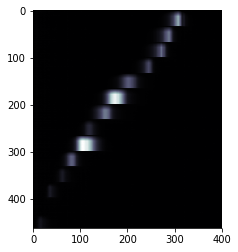

In [2]:
# Read the measurements in
Traces = []
for i in range(462*2):
    try:
        Name = 'Meas'+str(i).zfill(9)+'.csv'
        Data = pd.read_csv(Name)[32:-1]
        New = np.asarray(Data["#Thorlabs FTS"].str.split(";", n = 1, expand = True)).astype(np.float32)
        New[np.isnan(New)]
        Traces.append(New)
    except:
        print(i)
Traces = np.stack(Traces)

# Establish the new abscissa
NewX = np.linspace(340,740,400)

# Get the correction curve, resample
CorrectionCurve = np.load('correction_curve.npy')
CorrectionWVS = np.load('WOIstart.npy')
CorrectionCurve = interp(NewX,CorrectionWVS,CorrectionCurve)

# Average, smooth, resample and apply the correction curve
Traces = np.mean(Traces.reshape(2,462,3648,2),axis=0)
Traces = savgol(Traces, window_length=31, polyorder=3, axis=1)
Traces = np.vstack([interp(NewX,Traces[i,:,0],Traces[i,:,1])*CorrectionCurve for i in range(Traces.shape[0])])
plt.imshow(Traces,cmap = 'bone')

## Reduce the measurements to power, integrating over area

In [3]:
# Establish current levels - a priori
CurrentLevels = np.arange(0,4095+128,128) # 33 current levels
MeasurementLevels = 462/CurrentLevels.shape[0]
CurrentLevels = CurrentLevels[2:]

# Make Current-Response curves for all LEDs
Traces2 = Traces.reshape(14,33,400)
TracesClean = Traces2[:,2:,:] # get rid of measurement integration artefacts
Curves = np.mean(TracesClean, axis=-1)
Maxes = np.argmax(TracesClean, axis=-1)
LEDwvs = np.median(np.argmax(TracesClean, axis=-1)+340, axis=-1)

## Plot the LED shapes

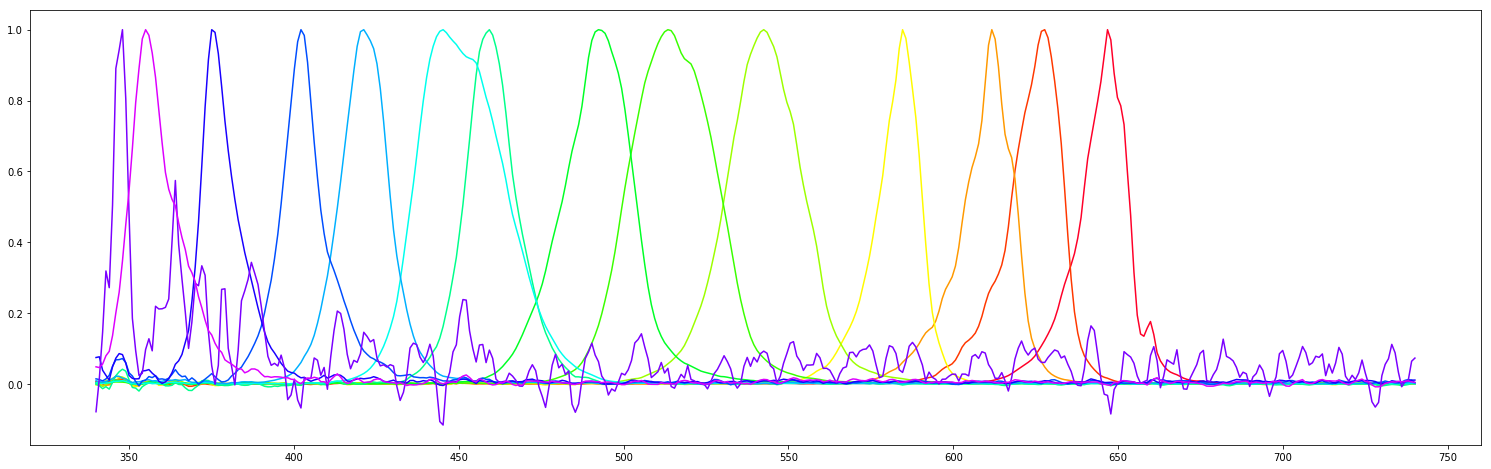

In [4]:
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1/14*i) for i in range(14)]

fig,ax = plt.subplots(1,1,figsize=(26,8))
[ax.plot(NewX,TracesClean[i,30,:]/np.amax(TracesClean[i,30,:]), c = colors[i]) for i in range(14)];

## Fit the observed power data with some functions. We will use these functions to predict needed current from needed power.

In [5]:
# we get Linear fits to the first 12 points in our curves
# we could have gotten Generalised Logistic Function fits to include the saturation but we don't
fromthis = 0
upto = 12
CurveFit = Curves[:,fromthis:upto]
SaturationMeans = np.mean(Curves[:,upto:],axis=-1)
CurveFit[:,-1] = SaturationMeans

def curve(Current,a,c):
    y = a*Current+c
    return y

def objfunc(x,Intensity,Currents):#currents is a global variable and cannot be fed/optimised in the objective
    a,c = x
    Predicted = np.asarray([curve(Current,a,c) for Current in Currents])
    return np.sum((Intensity - Predicted)**2)

Solutions = []
PredictedCurves = []
for i in range(14):
    Solutions.append(minim(objfunc, [2,1], args = (CurveFit[i,:],CurrentLevels[fromthis:upto])))                      
    PredictedCurves.append(curve(CurrentLevels[fromthis:upto], Solutions[i].x[0], Solutions[i].x[1]))  


In [6]:
# Generalised Logistic Function fits - may not work
upto2 = 25

def GlogF (x,b,q,v,K,A):
    """this simply produces a generalised logistic curve using x and the parameters"""
    return A + (K-A)/np.power((1+q*np.exp(-b*x)),(1/v))

def fit_generalised_logistic_function (data2fit, xinp):
    """fit GlogF to some data as a function of xinp
    - both 1d arrays"""
    bnds = ([-np.inf,-np.inf,0.0001,-np.inf,0], [np.inf,np.inf,np.inf,np.inf,np.inf])
    #bnds = ([-np.inf,-np.inf,0.01,-np.inf,-np.inf], [np.inf,np.inf,np.inf,np.inf,np.amin(data2fit)])   
    #bnds = ([-np.inf,-np.inf,-np.inf,-np.inf,0], [np.inf,np.inf,-0.01,np.inf,np.amin(data2fit)])
    #, bounds = bnds
    try:
        solution = cfit(GlogF, xinp, data2fit, bounds = bnds)[0]
    except:
        #print('fail')
        solution = cfit(GlogF, xinp, data2fit, method = 'dogbox', bounds = bnds)[0]
        
    return solution[0], solution[1], solution[2], solution[3], solution[4]

Solutions2 = []
PredictedCurves2 = []
for i in range(14):
    Solutions2.append(fit_generalised_logistic_function(Curves[i,:upto2],CurrentLevels[:upto2]))                     
    PredictedCurves2.append(GlogF(CurrentLevels[:upto2], Solutions2[i][0],Solutions2[i][1],Solutions2[i][2],Solutions2[i][3],Solutions2[i][4]))


## Plot the LED measurements and predicted curves.

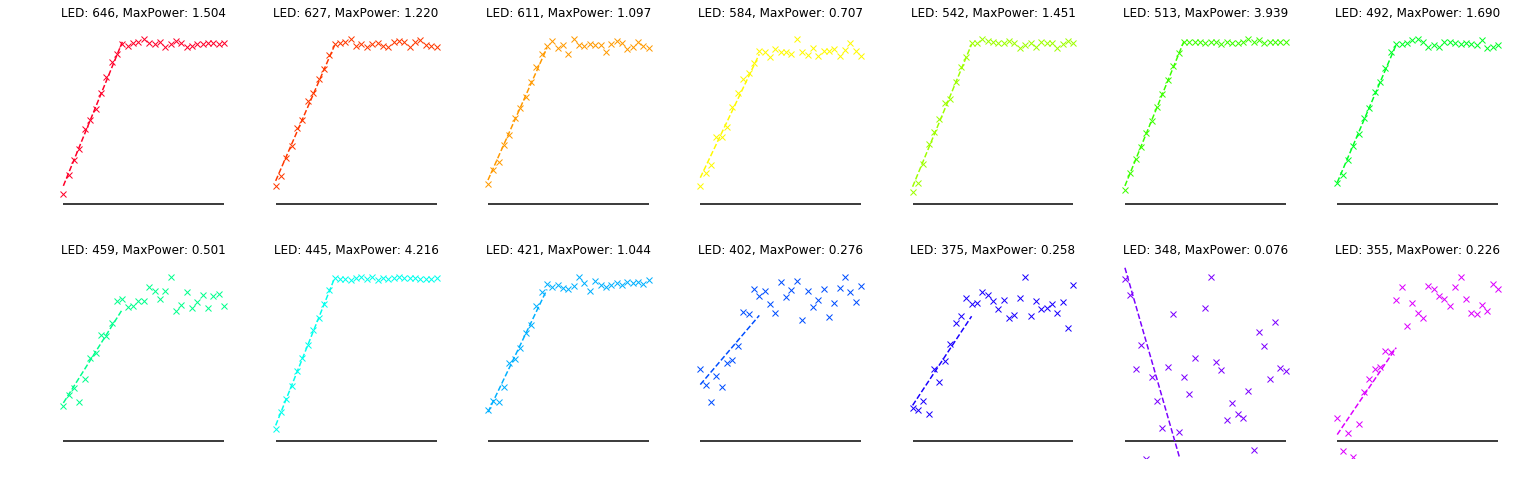

In [8]:
Columns = 7
Rows = 2

cm = plt.get_cmap('gist_rainbow')
colors = [cm(1/14*i) for i in range(14)]

fig,ax = plt.subplots(Rows,Columns, figsize = (26,8), sharey = False)

for i in range(Columns):
    for j in range(Rows):
        ax[j,i].plot(CurrentLevels,Curves[i+Columns*j,:], c = colors[i+Columns*j], marker = 'x', linestyle = 'None')
        ax[j,i].plot(CurrentLevels[fromthis:upto],PredictedCurves[i+Columns*j], c = colors[i+Columns*j], linestyle = '--')
        #ax[j,i].plot(CurrentLevels[:upto2],PredictedCurves2[i+Columns*j], c = colors[i+Columns*j], linestyle = '--')
        ax[j,i].axis('off')
        ax[j,i].set_ylim(0-0.1*np.amax(Curves[i+Columns*j,:]),np.amax(Curves[i+Columns*j,:])*1.1)
        
        xmin,xmax = CurrentLevels[0],CurrentLevels[-1]
        ax[j,i].hlines([0],xmin=xmin,xmax=xmax)
        MaxPower = np.amax(Curves[i+Columns*j,:])*1000
        ax[j,i].set_title('LED: ' + str(Maxes[i+Columns*j,-1]+340) + ', MaxPower: ' + "{:.3f}".format( MaxPower ))


## Let's find the least bright of the LEDs, excluding the UV.

In [10]:
LEDmax = np.amax(Curves[:,:],axis = 1)
#exclude UV and find minimum:
EqualLevel = np.amin(LEDmax[:-4])
EqualLevelInd = np.argmin(LEDmax[:-4])
print ('Excluding UV, the dimmest LED is: LED' + str(Maxes[EqualLevelInd,-1]+340) + ' at ' + "{:.3f}".format(EqualLevel*1000) + ' power')

Excluding UV, the dimmest LED is: LED459 at 0.501 power


In [12]:
EqualLevel*1.5

0.0007520622384295469

In [13]:
### Here we find the current needed to equalise non-uv LEDs. These are defined as the maximal currents.
def solve_for_current(y,a,c):
    Current = np.divide((y-c),a)
    return Current

EqualLevel = EqualLevel*1.5
CurrentEqualNonUV = [solve_for_current(EqualLevel, Solutions[i].x[0], Solutions[i].x[1])
                 for i in list(range(len(Solutions[:])))]

CurrentEqualUV = [solve_for_current(0.240/1000, Solutions[i].x[0], Solutions[i].x[1])
                 for i in list(range(len(Solutions[:])))]

CurrentEqual = np.hstack((CurrentEqualNonUV[:10],CurrentEqualUV[10:]))
CurrentEqual[-2]=0

CurrentEqual

array([ 882.54263076, 1067.81636769, 1202.01008252, 1952.7288137 ,
        928.05498381,  384.87503353,  783.77343218, 3397.66066778,
        384.4792269 , 1282.79659602, 2019.65769596, 2104.18512389,
          0.        , 2974.93404511])

## Example Stimulus produced: sweep from RED to GREEN to BLUE to UV

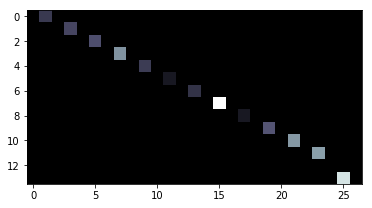

In [14]:
nleds = 14
Steps = np.transpose(np.vstack((np.zeros(nleds), np.zeros(nleds))))
Steps[0,0] = 1
AllSteps = np.hstack(([np.roll(Steps, shift = i, axis = 0) for i in range(nleds)]))
AllSteps[-1,:] = np.roll(AllSteps[-1,:],shift=-2)
PreAdaptation = np.ones((nleds,1), dtype = np.float64)*0#(1/15)
PreAllSteps = np.hstack((PreAdaptation, AllSteps))
PreAllSteps = PreAllSteps[:,:-2]
AllSteps.shape
SweepTimings = 100*np.ones(PreAllSteps.shape[-1])

# Here we multiply all the ONEs with the Equipowered LED values. No need to solve equations for now.
PreAllSteps = (PreAllSteps.transpose(1,0) * CurrentEqual.reshape(-1)).transpose(1,0)
plt.imshow(PreAllSteps,cmap='bone')

np.savetxt('2xsweep2s50pTIMING', SweepTimings.reshape(1,-1), fmt = '%.d', delimiter = ',', newline = '},{')
np.savetxt('2xsweep2s50p', PreAllSteps, fmt = '%.d', delimiter = ',', newline = '},{')

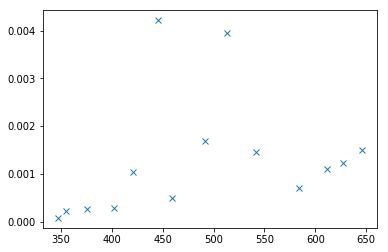

In [291]:
## Plot the max LED values
plt.plot(LEDwvs,LEDmax,'x')

In [51]:
CorrectionY = np.load('correction_curve.npy')
CorrectionX = np.load('WOIstart.npy')

CorrectionTable = pd.DataFrame(data = np.vstack((CorrectionX,CorrectionY)).T, columns = ['Wavelength','Correction'])
CorrectionTable.to_csv(r'Correction4Takeshi.csv')